In [9]:
import os, sys, re
import json
import numpy as np
import torch 
from torch.utils.data import Dataset, DataLoader
import polars as pl
from polars import selectors as cs
from functools import partial
from datasets import Dataset as DSet
from datasets import DatasetDict as DDict
from datasets import concatenate_datasets

import pandas as pd

from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM, Trainer, TrainingArguments, TextDataset, RobertaForMaskedLM

In [419]:
import matplotlib.pyplot as plt

In [10]:
from sklearn.model_selection import train_test_split

In [21]:
from sqlalchemy import MetaData, Table, select, create_engine, and_, or_, not_

In [23]:
import sqlalchemy, random

In [22]:
training_db_path = r"C:\Users\breuh\OneDrive\proggy\python\MTG\roberta\data_setups\training_database.db"
training_db_path = os.path.normpath(training_db_path)

engine_path = "sqlite:///" + training_db_path

In [14]:
engine = create_engine(engine_path)

In [18]:
metadata = MetaData()
metadata.reflect(bind=engine)

scryfall_pruned = metadata.tables["scryfall_pruned"] 

In [188]:
with engine.connect() as conn:
    query = select(scryfall_pruned.c.name).where(scryfall_pruned.c.type_line.ilike("%land%"))
    lands = [row[0] for row in conn.execute(query).all()]

In [167]:
gamedata_tablename_pattern = re.compile(r"([A-Z]{3})_(\D+)")
gamedata_tablenames = list(filter(gamedata_tablename_pattern.match, metadata.tables.keys()))

def get_random_table(tablenames=gamedata_tablenames):
    tablename = random.choice(tablenames)
    table = metadata.tables[tablename]
    return table


In [404]:
def get_random_combo_from_table(table, N=2, landnames = lands):
    # columns to *test* (> 0); exclude 'won' from the condition set
    candidates = [c for c in table.c if c.key != "won" and c.key not in landnames]
    combo = random.sample(candidates, N)              # list[Column]
    cols_to_select = [*combo, table.c.won]           # include 'won' in SELECT

    query = select(*cols_to_select).where(and_(*[c > 0 for c in combo]))

    with engine.connect() as conn:
        rows = conn.execute(query).all()

    tablename = table.name
    setname, gametype = gamedata_tablename_pattern.match(tablename).groups()
    othertables = [t for k, t in metadata.tables.items() if k.startswith(setname) and k != tablename]

    additional_results = []
    for othertable in othertables:
        if not all(c.key in othertable.c for c in combo):
            continue
        cols_to_select = [othertable.c[c.key] for c in combo] + [othertable.c.won]
        query = select(*cols_to_select).where(and_(*[c > 0 for c in cols_to_select[:-1]]))
        with engine.connect() as conn:
            additional_results.extend(conn.execute(query).all())
    
    results = rows + additional_results

    if len(results) == 0:
        return None, None, combo
    rows = np.array(results)
    return rows.shape[0], np.mean(rows, axis = 0)[-1].item(), [c.key for c in combo]

In [405]:
def generate_random_combo(N=2):
    random_table = get_random_table()
    N, wr, cols = get_random_combo_from_table(random_table, N)

    return N, wr, cols

In [433]:
two_combos = []
while len(two_combos) < 500:
    N, wr, cols = generate_random_combo(2)
    if N is None:
        continue
    two_combos.append((N, wr, cols))

three_combos = []
while len(three_combos) < 500:
    N, wr, cols = generate_random_combo(3)
    if N is None:
        continue
    three_combos.append((N, wr, cols))

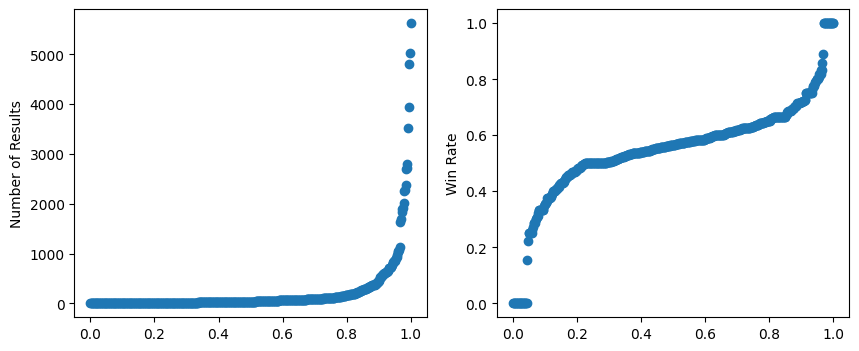

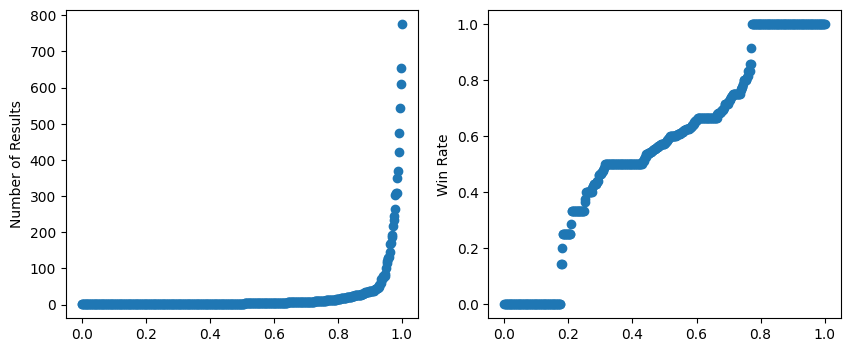

In [435]:
for combo in [two_combos, three_combos]:
    ns = [c[0] for c in combo]
    wrs = [c[1] for c in combo]

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].scatter(np.linspace(0, 1, len(ns)), sorted(ns))
    ax[1].scatter(np.linspace(0, 1, len(wrs)), sorted(wrs))

    ax[0].set_ylabel("Number of Results")
    ax[1].set_ylabel("Win Rate")
    plt.show()

In [432]:
Ns = [c[0] for c in combos]


sorted(Ns)[int(0.75 * (len(Ns)-1))]

171

In [197]:
random_table.name

'LTR_PremierDraft'

In [172]:
np.linspace(0, 1, 11) * np.linspace(0, 1, 11)[::-1]

array([0.  , 0.09, 0.16, 0.21, 0.24, 0.25, 0.24, 0.21, 0.16, 0.09, 0.  ])

In [118]:
gamedata_tables = [t for k, t in metadata.tables.items() if not k.startswith("scryfall")]

In [155]:
N, wr, cols = generate_random_combo(gamedata_tables[-4], 2)
cols, wr, N, wr*(1-wr)/(N-1)

([Column("Mage's Attendant", INTEGER(), table=<SNC_TradSealed>),
  Column('Lord Xander, the Collector', INTEGER(), table=<SNC_TradSealed>)],
 0.8,
 5,
 0.039999999999999994)

In [156]:
query = select(scryfall_pruned.c.set).where(scryfall_pruned.c.name.in_([col.key for col in cols]))
with engine.connect() as conn:
    rows = conn.execute(query).all()
rows

[('snc',), ('clb',)]

In [97]:
cols[0].key

'Terisian Mindbreaker'

In [19]:
scryfall_pruned.columns.keys()

['mana_cost',
 'type_line',
 'power',
 'toughness',
 'oracle_text',
 'colors',
 'name',
 'cmc',
 'color_identity',
 'keywords',
 'set']

In [ ]:
query = scryfall_pruned.select().where

In [10]:
query = metadata.tables["scryfall_finetuning"].select()

with engine.connect() as conn:
    result = conn.execute(query)
    columns = result.keys()
    result = result.fetchall()
data   = [tuple(res) for res in result]
scryfall_df = pl.DataFrame(data, schema=columns)

In [11]:
query = metadata.tables["ruleset"].select()

with engine.connect() as conn:
    result  = conn.execute(query)
    columns = result.keys()
    result  = result.fetchall()

data = [tuple(res) for res in result]
ruleset_df = pl.DataFrame(data, schema=columns)


In [12]:
ruleset_df

text
str
"""1. Game Concep…"
"""100. General 1…"
"""100.1. These M…"
"""100.1a A two-p…"
"""100.1b A multi…"
"""100.2. To play…"
"""100.2a In cons…"
"""100.2b In limi…"
"""100.2c Command…"


In [13]:
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

In [14]:
roberta = RobertaForMaskedLM.from_pretrained('roberta-base')

In [15]:
# roberta_state_dict_path = r"C:\Users\breuh\OneDrive\proggy\python\MTG\roberta\finetuning\roberta_finetuned.pt"
# roberta_state_dict = torch.load(roberta_state_dict_path, map_location='cpu')
# roberta.load_state_dict(roberta_state_dict)

In [16]:
import torch.nn as nn 

models_path = r"C:\Users\breuh\OneDrive\proggy\python\MTG\roberta\finetuning\models"
models_path = os.path.normpath(models_path)

if models_path not in sys.path:
    sys.path.insert(0, models_path)

In [17]:
from LoRA import LoRALinear

In [18]:
def replace_with_loraLinear(module, name_to_replace, r=15, dropout_=0.):
    parent_module_dict = dict(module.named_modules())
    for name, child in module.named_modules():
        if isinstance(name_to_replace, str):
            name_check = name.endswith(name_to_replace)
        if isinstance(name_to_replace, list):
            name_check = True in [name.endswith(n) for n in name_to_replace]
        if not name_check: continue

        parent_name, child_name = name.rsplit('.', 1)
        parent_module = parent_module_dict[parent_name]
        
        if isinstance(child, nn.Linear):
            # Replace the 'query' module with LoRA module
            in_features = child.in_features
            out_features= child.out_features
            weight = child.weight.data
            bias   = child.bias.data 
            loralinear = LoRALinear(in_features, out_features, r=r, lora_dropout=dropout_, frozen_weight=weight,\
                                    frozen_bias=bias)

            setattr(parent_module, child_name, loralinear)




In [19]:
lora_names = ["key", "query", "value", "dense"]

In [20]:
n_false = 0
n_true  = 0
params_false = 0
params_true  = 0
for name, param in roberta.named_parameters():
    parent_name, param_type = name.rsplit('.', 1)
    flag = None
    if param_type == 'weight':
        flag = True
    if isinstance(lora_names, str):
        if not parent_name.endswith(lora_names):
            flag = True
    if isinstance(lora_names, list):
        if not (True in [parent_name.endswith(lora_name) for lora_name in lora_names]):
            flag = True
    if flag:
        param.requires_grad = False 
        params_false += np.prod(param.data.shape)
        n_false += 1 
        continue 
    param.requires_grad = True 
    params_true += np.prod(param.data.shape)
    n_true += 1 

In [21]:
n_total = n_true + n_false

n_true / n_total, n_false / n_total, n_total

(0.3613861386138614, 0.6386138613861386, 202)

In [22]:
params_total = params_false + params_true 

params_true / params_total, params_false / params_total, params_total*1e-6

(0.0006713209565428665, 0.9993286790434571, 124.69743299999999)

In [23]:
replace_with_loraLinear(roberta, lora_names, r=7, dropout_=.05)

In [24]:
params_false = 0
params_true  = 0
for name, param in roberta.named_parameters():
    if param.requires_grad is False:
        params_false += np.prod(param.data.shape)
    else:
        params_true += np.prod(param.data.shape)
        


In [25]:
params_total = params_false + params_true 

params_true / params_total, params_false / params_total, params_total*1e-6

(0.00997605446616847, 0.9900239455338316, 125.869401)

In [26]:
class tuning_dataset(Dataset):
    def __init__(self, data_array):
        self.txt = data_array

    def __len__(self):
        return len(self.txt)

    def __getitem__(self, index):
        return self.txt[index]

In [27]:
tokenizer.model_max_length

512

In [28]:
tokenizer_ = lambda x: tokenizer(x['text'], return_tensors='pt', max_length=tokenizer.model_max_length, truncation=True, padding='max_length') 

In [29]:
scryfall_df = scryfall_df.select(pl.col('text'))

In [32]:
scryfall_df[0].item()

'name: Farsight Adept; type line: Creature — Kor Wizard; keywords: ; color identity: W; colors: W; mana value: 3.0; mana cost: {2}{W}; power: 3; toughness: 3; text box: When Farsight Adept enters the battlefield, you and target opponent each draw a card.'

In [29]:
train_idx, val_idx = train_test_split(np.arange(len(scryfall_df)), test_size=.125)

scryfall_val = scryfall_df[val_idx]

train_df = pl.concat([ruleset_df, scryfall_df[train_idx]])

train_df = train_df.to_pandas()
scryfall_val = scryfall_val.to_pandas()

In [30]:
train_DSet = DSet.from_pandas(train_df, preserve_index=False)
val_DSet   = DSet.from_pandas(scryfall_val, preserve_index=False)

train_DSet = train_DSet.map(tokenizer_, batched=True, batch_size=1000)
val_DSet   = val_DSet.map(tokenizer_, batched=True, batch_size=1000)

Map:   0%|          | 0/26979 [00:00<?, ? examples/s]

Map:   0%|          | 0/3192 [00:00<?, ? examples/s]

In [31]:
train_DSet

Dataset({
    features: ['text', 'input_ids', 'attention_mask'],
    num_rows: 26979
})

In [32]:
class mtg_dataset(Dataset):
    def __init__(self, mtg_DSet):
        self.dataset = mtg_DSet

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx]

In [33]:
train_dset = mtg_dataset(train_DSet)
val_dset   = mtg_dataset(val_DSet)

In [34]:
def mlm_data_collator(batch, tokenizer, mask_prob=.15, masked_prob=.8, replaced_prob=.10, ignore_index=-100):

    input_ids = [torch.tensor(b['input_ids']) for b in batch]
    attention_mask = [torch.tensor(b['attention_mask']) for b in batch]

    input_ids = torch.stack(input_ids, dim=0)
    attention_mask = torch.stack(attention_mask, dim=0)

    labels = input_ids.detach().clone()
    pad_mask     = (labels == tokenizer.pad_token_id)

    replaced_prob += masked_prob 

    prob         = torch.rand(*input_ids.shape)
    mask_mask    = (prob <= mask_prob) & ~pad_mask

    prob         = torch.rand(*input_ids.shape)
    masked_mask  = (prob <= masked_prob) & mask_mask 
    replaced_mask= (prob >  masked_prob) & (prob <= replaced_prob) & mask_mask
    
    # keeped_mask  = (prob > replaced_prob) & (prob <= 1) & mask_mask
    # print(prob.shape, mask_mask.sum()/np.prod(mask_mask.shape), replaced_mask.sum()/np.prod(mask_mask.shape), keeped_mask.sum()/np.prod(mask_mask.shape))

    ignore_mask  = ~mask_mask
    
    labels[ignore_mask] = ignore_index

    input_ids[masked_mask] = tokenizer.mask_token_id
    input_ids[replaced_mask] = torch.randint(0, tokenizer.vocab_size, size=labels[replaced_mask].shape)

    return input_ids.long(), attention_mask.long(), labels.long()

In [35]:
B = 25

In [36]:
train_dl = DataLoader(train_dset, batch_size=B, shuffle=True, collate_fn=lambda x: mlm_data_collator(x, tokenizer), pin_memory=True)
val_dl   = DataLoader(val_dset, batch_size=B, shuffle=True, collate_fn=lambda x: mlm_data_collator(x, tokenizer))



In [37]:
lr_max = 5e-6
div_factor=1e3
epochs= 15

optimizer = torch.optim.AdamW(roberta.parameters(), lr=lr_max)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=lr_max, div_factor=div_factor, epochs=epochs, steps_per_epoch=len(train_dl))

F_loss = torch.nn.CrossEntropyLoss(label_smoothing=.05)

In [38]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
device

'cuda'

In [39]:
tokenizer.convert_tokens_to_string( tokenizer.convert_ids_to_tokens([1380, 887, 335, 3333]))

' class fourth information doctors'

In [40]:
roberta.to(device)

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): LoRALinear(
                in_features=768, out_features=768, bias=True
                (lora_dropout): Dropout(p=0.05, inplace=False)
              )
              (key): LoRALinear(
                in_features=768, out_features=768, bias=True
                (lora_dropout): Dropout(p=0.05, inplace=False)
              )
              (value): LoRALinear(
                in_features=768, out_features=768, bias=

roberta.to(device)
for x, attention, y in train_dl:

    roberta.eval()
    x = x.to(device)
    y = y.to(device)
    attention = attention.to(device)
    with torch.no_grad():
        output = roberta(x, attention_mask=attention)
    logits = output.logits.detach().cpu()
    predictions = torch.argmax(logits, dim=-1)

    masked_mask = y.detach().cpu() != -100

    pad_mask    = ~masked_mask & (x.detach().cpu() == tokenizer.mask_token_id)
    

    output_text = x.detach().cpu()
    output_text[masked_mask] = predictions[masked_mask]
    output_text[pad_mask] = tokenizer.pad_token_id
    print(logits.shape)
    print(predictions.shape)
    print(tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(x[0])))
    print(tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(output_text[0])))
    1/0
    

In [41]:
import time

import matplotlib.pyplot as plt

Training Batch 1: Median Loss = 2.950 (0.3 sec/batch)
Training Batch 26: Median Loss = 2.852 (2.9 sec/batch)
Training Batch 51: Median Loss = 2.848 (2.9 sec/batch)
Training Batch 76: Median Loss = 2.832 (2.9 sec/batch)
Training Batch 101: Median Loss = 2.848 (2.9 sec/batch)
Training Batch 126: Median Loss = 2.847 (2.9 sec/batch)
Training Batch 151: Median Loss = 2.848 (2.9 sec/batch)
Training Batch 176: Median Loss = 2.851 (3.4 sec/batch)
Training Batch 201: Median Loss = 2.848 (5.0 sec/batch)
Training Batch 226: Median Loss = 2.848 (4.3 sec/batch)
Training Batch 251: Median Loss = 2.847 (4.8 sec/batch)
Training Batch 276: Median Loss = 2.846 (4.8 sec/batch)
Training Batch 301: Median Loss = 2.840 (4.8 sec/batch)
Training Batch 326: Median Loss = 2.835 (5.2 sec/batch)
Training Batch 351: Median Loss = 2.837 (4.9 sec/batch)
Training Batch 376: Median Loss = 2.840 (4.9 sec/batch)
Training Batch 401: Median Loss = 2.833 (4.9 sec/batch)
Training Batch 426: Median Loss = 2.832 (7.0 sec/batc

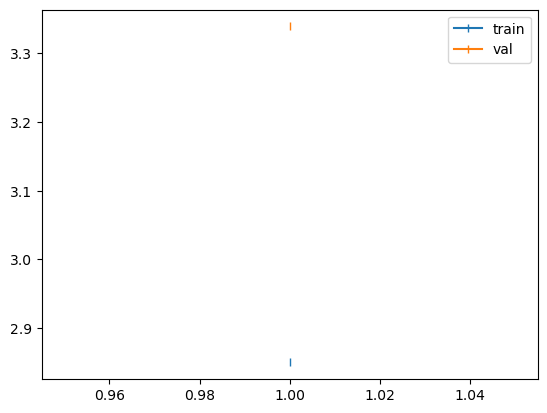

Training Batch 1: Median Loss = 2.914 (0.3 sec/batch)
Training Batch 26: Median Loss = 2.876 (6.5 sec/batch)
Training Batch 51: Median Loss = 2.829 (5.2 sec/batch)
Training Batch 76: Median Loss = 2.796 (5.2 sec/batch)
Training Batch 101: Median Loss = 2.815 (5.9 sec/batch)
Training Batch 126: Median Loss = 2.810 (6.3 sec/batch)
Training Batch 151: Median Loss = 2.802 (6.0 sec/batch)
Training Batch 176: Median Loss = 2.810 (5.3 sec/batch)
Training Batch 201: Median Loss = 2.807 (5.2 sec/batch)
Training Batch 226: Median Loss = 2.815 (5.6 sec/batch)
Training Batch 251: Median Loss = 2.814 (6.0 sec/batch)
Training Batch 276: Median Loss = 2.815 (5.6 sec/batch)
Training Batch 301: Median Loss = 2.814 (5.2 sec/batch)
Training Batch 326: Median Loss = 2.815 (5.2 sec/batch)
Training Batch 351: Median Loss = 2.814 (5.2 sec/batch)
Training Batch 376: Median Loss = 2.812 (5.2 sec/batch)
Training Batch 401: Median Loss = 2.810 (5.2 sec/batch)
Training Batch 426: Median Loss = 2.805 (5.2 sec/batc

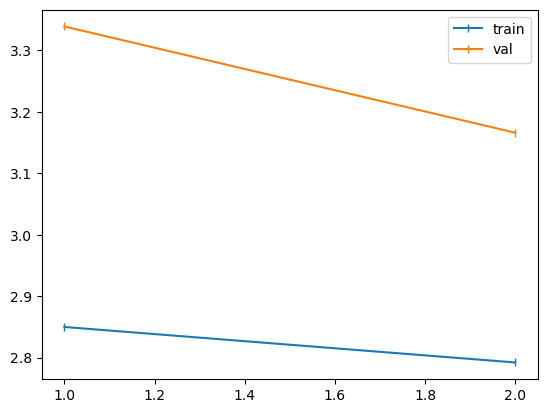

Training Batch 1: Median Loss = 2.697 (0.2 sec/batch)
Training Batch 26: Median Loss = 2.654 (5.2 sec/batch)
Training Batch 51: Median Loss = 2.686 (5.2 sec/batch)
Training Batch 76: Median Loss = 2.701 (5.2 sec/batch)
Training Batch 101: Median Loss = 2.703 (5.2 sec/batch)
Training Batch 126: Median Loss = 2.702 (5.2 sec/batch)
Training Batch 151: Median Loss = 2.712 (5.2 sec/batch)
Training Batch 176: Median Loss = 2.698 (5.2 sec/batch)
Training Batch 201: Median Loss = 2.701 (5.2 sec/batch)
Training Batch 226: Median Loss = 2.700 (5.2 sec/batch)
Training Batch 251: Median Loss = 2.699 (5.2 sec/batch)
Training Batch 276: Median Loss = 2.698 (5.2 sec/batch)
Training Batch 301: Median Loss = 2.702 (5.2 sec/batch)
Training Batch 326: Median Loss = 2.702 (5.2 sec/batch)
Training Batch 351: Median Loss = 2.702 (5.2 sec/batch)
Training Batch 376: Median Loss = 2.695 (5.2 sec/batch)
Training Batch 401: Median Loss = 2.686 (5.2 sec/batch)
Training Batch 426: Median Loss = 2.686 (5.2 sec/batc

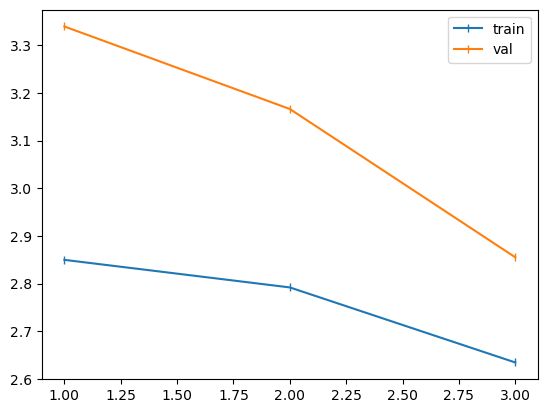

Training Batch 1: Median Loss = 2.705 (0.2 sec/batch)
Training Batch 26: Median Loss = 2.606 (5.2 sec/batch)
Training Batch 51: Median Loss = 2.529 (5.2 sec/batch)
Training Batch 76: Median Loss = 2.512 (5.2 sec/batch)
Training Batch 101: Median Loss = 2.511 (5.2 sec/batch)
Training Batch 126: Median Loss = 2.512 (5.2 sec/batch)
Training Batch 151: Median Loss = 2.519 (5.2 sec/batch)
Training Batch 176: Median Loss = 2.515 (5.2 sec/batch)
Training Batch 201: Median Loss = 2.513 (5.2 sec/batch)
Training Batch 226: Median Loss = 2.512 (5.2 sec/batch)
Training Batch 251: Median Loss = 2.505 (5.2 sec/batch)
Training Batch 276: Median Loss = 2.515 (5.2 sec/batch)
Training Batch 301: Median Loss = 2.505 (5.2 sec/batch)
Training Batch 326: Median Loss = 2.503 (5.2 sec/batch)
Training Batch 351: Median Loss = 2.497 (5.2 sec/batch)
Training Batch 376: Median Loss = 2.494 (5.2 sec/batch)
Training Batch 401: Median Loss = 2.496 (5.2 sec/batch)
Training Batch 426: Median Loss = 2.493 (5.2 sec/batc

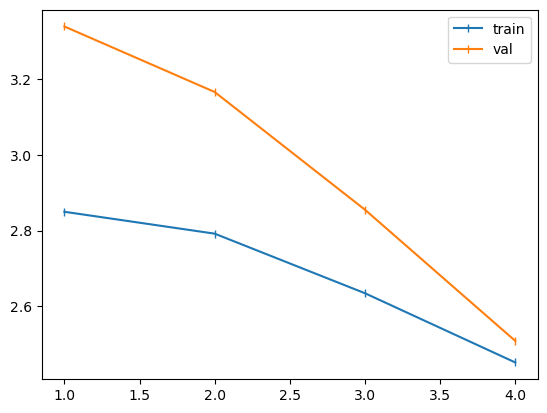

Training Batch 1: Median Loss = 2.313 (0.2 sec/batch)
Training Batch 26: Median Loss = 2.351 (5.2 sec/batch)
Training Batch 51: Median Loss = 2.356 (5.2 sec/batch)
Training Batch 76: Median Loss = 2.355 (5.2 sec/batch)
Training Batch 101: Median Loss = 2.353 (5.2 sec/batch)
Training Batch 126: Median Loss = 2.347 (5.2 sec/batch)
Training Batch 151: Median Loss = 2.346 (5.2 sec/batch)
Training Batch 176: Median Loss = 2.345 (5.2 sec/batch)
Training Batch 201: Median Loss = 2.345 (5.2 sec/batch)
Training Batch 226: Median Loss = 2.345 (5.2 sec/batch)
Training Batch 251: Median Loss = 2.342 (5.2 sec/batch)
Training Batch 276: Median Loss = 2.344 (5.2 sec/batch)
Training Batch 301: Median Loss = 2.339 (5.2 sec/batch)
Training Batch 326: Median Loss = 2.342 (5.2 sec/batch)
Training Batch 351: Median Loss = 2.336 (5.2 sec/batch)
Training Batch 376: Median Loss = 2.336 (5.2 sec/batch)
Training Batch 401: Median Loss = 2.335 (5.2 sec/batch)
Training Batch 426: Median Loss = 2.330 (5.2 sec/batc

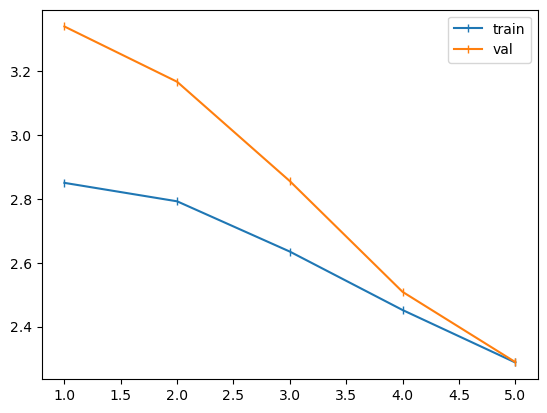

Training Batch 1: Median Loss = 2.362 (0.2 sec/batch)
Training Batch 26: Median Loss = 2.263 (5.2 sec/batch)
Training Batch 51: Median Loss = 2.235 (5.2 sec/batch)
Training Batch 76: Median Loss = 2.212 (5.2 sec/batch)
Training Batch 101: Median Loss = 2.201 (5.2 sec/batch)
Training Batch 126: Median Loss = 2.212 (5.2 sec/batch)
Training Batch 151: Median Loss = 2.210 (5.2 sec/batch)
Training Batch 176: Median Loss = 2.199 (5.2 sec/batch)
Training Batch 201: Median Loss = 2.212 (5.2 sec/batch)
Training Batch 226: Median Loss = 2.212 (5.2 sec/batch)
Training Batch 251: Median Loss = 2.212 (5.2 sec/batch)
Training Batch 276: Median Loss = 2.211 (5.2 sec/batch)
Training Batch 301: Median Loss = 2.210 (5.2 sec/batch)
Training Batch 326: Median Loss = 2.209 (5.2 sec/batch)
Training Batch 351: Median Loss = 2.207 (5.2 sec/batch)
Training Batch 376: Median Loss = 2.199 (5.2 sec/batch)
Training Batch 401: Median Loss = 2.193 (5.2 sec/batch)
Training Batch 426: Median Loss = 2.193 (5.2 sec/batc

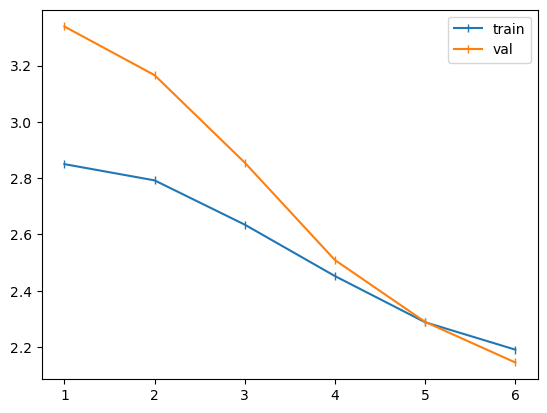

Training Batch 1: Median Loss = 2.249 (0.2 sec/batch)
Training Batch 26: Median Loss = 2.138 (5.2 sec/batch)
Training Batch 51: Median Loss = 2.153 (5.2 sec/batch)
Training Batch 76: Median Loss = 2.154 (5.2 sec/batch)
Training Batch 101: Median Loss = 2.152 (5.2 sec/batch)
Training Batch 126: Median Loss = 2.146 (5.2 sec/batch)
Training Batch 151: Median Loss = 2.148 (5.2 sec/batch)
Training Batch 176: Median Loss = 2.148 (5.2 sec/batch)
Training Batch 201: Median Loss = 2.141 (5.2 sec/batch)
Training Batch 226: Median Loss = 2.142 (5.2 sec/batch)
Training Batch 251: Median Loss = 2.143 (5.2 sec/batch)
Training Batch 276: Median Loss = 2.142 (5.2 sec/batch)
Training Batch 301: Median Loss = 2.148 (5.2 sec/batch)
Training Batch 326: Median Loss = 2.148 (5.2 sec/batch)
Training Batch 351: Median Loss = 2.148 (5.2 sec/batch)
Training Batch 376: Median Loss = 2.147 (5.2 sec/batch)
Training Batch 401: Median Loss = 2.143 (5.2 sec/batch)
Training Batch 426: Median Loss = 2.141 (5.2 sec/batc

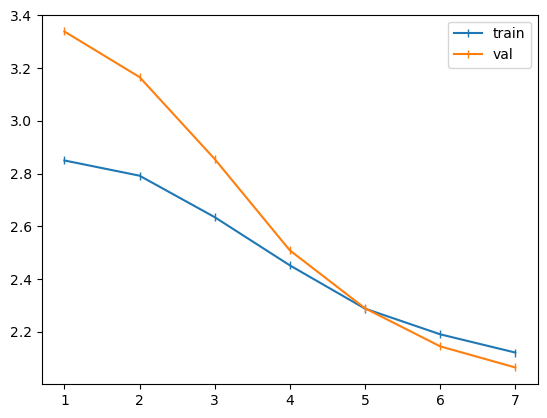

Training Batch 1: Median Loss = 2.031 (0.2 sec/batch)
Training Batch 26: Median Loss = 2.020 (5.2 sec/batch)
Training Batch 51: Median Loss = 2.074 (5.2 sec/batch)
Training Batch 76: Median Loss = 2.077 (5.2 sec/batch)
Training Batch 101: Median Loss = 2.076 (5.2 sec/batch)
Training Batch 126: Median Loss = 2.075 (5.2 sec/batch)
Training Batch 151: Median Loss = 2.075 (5.2 sec/batch)
Training Batch 176: Median Loss = 2.081 (5.2 sec/batch)
Training Batch 201: Median Loss = 2.087 (5.2 sec/batch)
Training Batch 226: Median Loss = 2.086 (5.2 sec/batch)
Training Batch 251: Median Loss = 2.082 (5.2 sec/batch)
Training Batch 276: Median Loss = 2.081 (5.2 sec/batch)
Training Batch 301: Median Loss = 2.082 (5.2 sec/batch)
Training Batch 326: Median Loss = 2.086 (5.2 sec/batch)
Training Batch 351: Median Loss = 2.081 (5.2 sec/batch)
Training Batch 376: Median Loss = 2.079 (5.2 sec/batch)
Training Batch 401: Median Loss = 2.078 (5.2 sec/batch)
Training Batch 426: Median Loss = 2.076 (5.2 sec/batc

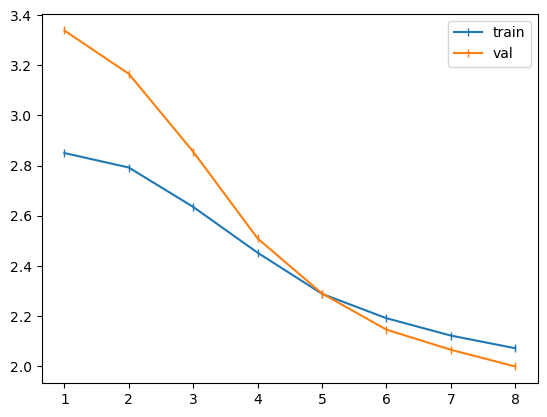

Training Batch 1: Median Loss = 2.072 (0.2 sec/batch)
Training Batch 26: Median Loss = 2.052 (5.2 sec/batch)
Training Batch 51: Median Loss = 2.036 (5.2 sec/batch)
Training Batch 76: Median Loss = 2.052 (5.2 sec/batch)
Training Batch 101: Median Loss = 2.065 (5.2 sec/batch)
Training Batch 126: Median Loss = 2.060 (5.2 sec/batch)
Training Batch 151: Median Loss = 2.044 (5.2 sec/batch)
Training Batch 176: Median Loss = 2.045 (5.2 sec/batch)
Training Batch 201: Median Loss = 2.049 (5.2 sec/batch)
Training Batch 226: Median Loss = 2.048 (5.2 sec/batch)
Training Batch 251: Median Loss = 2.044 (5.2 sec/batch)
Training Batch 276: Median Loss = 2.045 (5.2 sec/batch)
Training Batch 301: Median Loss = 2.046 (5.2 sec/batch)
Training Batch 326: Median Loss = 2.048 (5.2 sec/batch)
Training Batch 351: Median Loss = 2.049 (5.2 sec/batch)
Training Batch 376: Median Loss = 2.046 (5.2 sec/batch)
Training Batch 401: Median Loss = 2.046 (5.2 sec/batch)
Training Batch 426: Median Loss = 2.046 (5.2 sec/batc

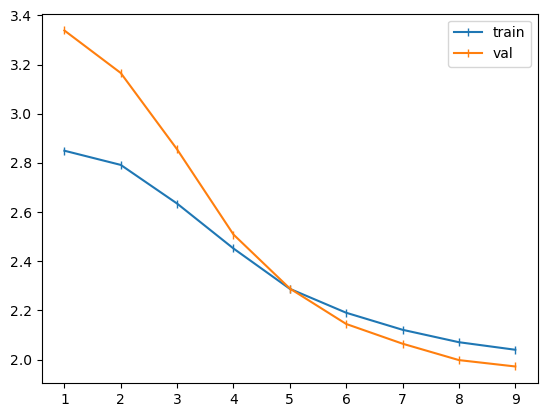

Training Batch 1: Median Loss = 2.046 (0.2 sec/batch)
Training Batch 26: Median Loss = 2.000 (5.2 sec/batch)
Training Batch 51: Median Loss = 2.001 (5.2 sec/batch)
Training Batch 76: Median Loss = 2.014 (5.2 sec/batch)
Training Batch 101: Median Loss = 2.013 (5.2 sec/batch)
Training Batch 126: Median Loss = 2.013 (5.2 sec/batch)
Training Batch 151: Median Loss = 2.012 (5.2 sec/batch)
Training Batch 176: Median Loss = 2.005 (5.2 sec/batch)
Training Batch 201: Median Loss = 2.013 (5.2 sec/batch)
Training Batch 226: Median Loss = 2.014 (5.2 sec/batch)
Training Batch 251: Median Loss = 2.015 (5.2 sec/batch)
Training Batch 276: Median Loss = 2.013 (5.2 sec/batch)
Training Batch 301: Median Loss = 2.013 (5.2 sec/batch)
Training Batch 326: Median Loss = 2.014 (5.2 sec/batch)
Training Batch 351: Median Loss = 2.015 (5.2 sec/batch)
Training Batch 376: Median Loss = 2.015 (5.2 sec/batch)
Training Batch 401: Median Loss = 2.017 (5.2 sec/batch)
Training Batch 426: Median Loss = 2.017 (5.2 sec/batc

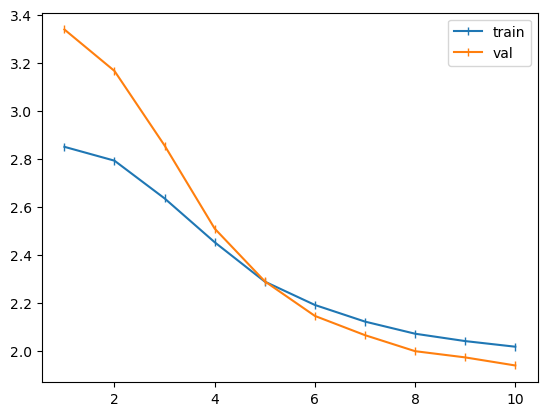

Training Batch 1: Median Loss = 2.024 (0.2 sec/batch)
Training Batch 26: Median Loss = 2.015 (5.2 sec/batch)
Training Batch 51: Median Loss = 2.024 (5.2 sec/batch)
Training Batch 76: Median Loss = 2.017 (5.2 sec/batch)
Training Batch 101: Median Loss = 2.018 (5.2 sec/batch)
Training Batch 126: Median Loss = 2.005 (5.2 sec/batch)
Training Batch 151: Median Loss = 2.006 (5.2 sec/batch)
Training Batch 176: Median Loss = 2.005 (5.2 sec/batch)
Training Batch 201: Median Loss = 1.999 (5.2 sec/batch)
Training Batch 226: Median Loss = 2.001 (5.2 sec/batch)
Training Batch 251: Median Loss = 2.000 (5.2 sec/batch)
Training Batch 276: Median Loss = 1.998 (5.2 sec/batch)
Training Batch 301: Median Loss = 1.997 (5.2 sec/batch)
Training Batch 326: Median Loss = 1.998 (5.2 sec/batch)
Training Batch 351: Median Loss = 1.998 (5.2 sec/batch)
Training Batch 376: Median Loss = 1.999 (5.2 sec/batch)
Training Batch 401: Median Loss = 1.999 (5.2 sec/batch)
Training Batch 426: Median Loss = 2.001 (5.2 sec/batc

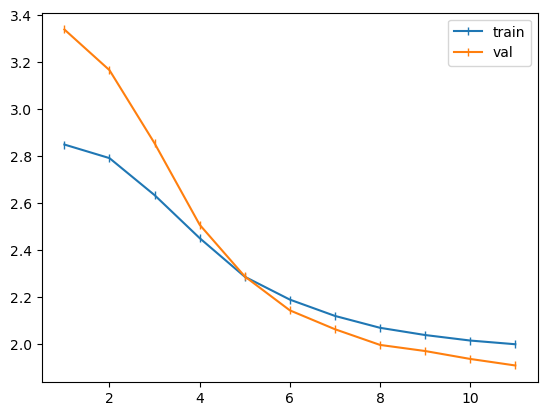

Training Batch 1: Median Loss = 2.141 (0.2 sec/batch)
Training Batch 26: Median Loss = 1.989 (5.2 sec/batch)
Training Batch 51: Median Loss = 1.984 (5.2 sec/batch)
Training Batch 76: Median Loss = 1.978 (5.2 sec/batch)
Training Batch 101: Median Loss = 1.972 (5.2 sec/batch)
Training Batch 126: Median Loss = 1.975 (5.2 sec/batch)
Training Batch 151: Median Loss = 1.978 (5.2 sec/batch)
Training Batch 176: Median Loss = 1.978 (5.2 sec/batch)
Training Batch 201: Median Loss = 1.979 (5.2 sec/batch)
Training Batch 226: Median Loss = 1.979 (5.2 sec/batch)
Training Batch 251: Median Loss = 1.978 (5.2 sec/batch)
Training Batch 276: Median Loss = 1.977 (5.2 sec/batch)
Training Batch 301: Median Loss = 1.975 (5.2 sec/batch)
Training Batch 326: Median Loss = 1.975 (5.2 sec/batch)
Training Batch 351: Median Loss = 1.975 (5.2 sec/batch)
Training Batch 376: Median Loss = 1.977 (5.2 sec/batch)
Training Batch 401: Median Loss = 1.976 (5.2 sec/batch)
Training Batch 426: Median Loss = 1.977 (5.2 sec/batc

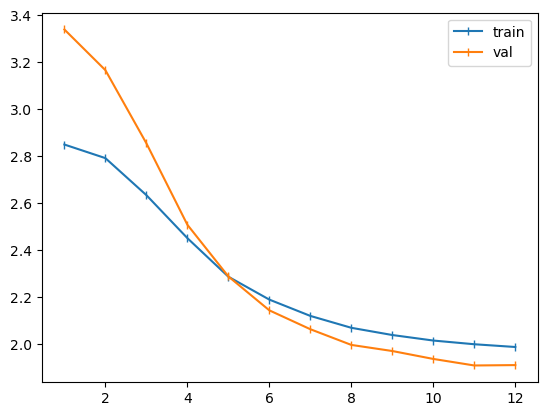

Training Batch 1: Median Loss = 2.034 (0.2 sec/batch)
Training Batch 26: Median Loss = 1.952 (5.2 sec/batch)
Training Batch 51: Median Loss = 1.967 (5.2 sec/batch)
Training Batch 76: Median Loss = 1.976 (5.2 sec/batch)
Training Batch 101: Median Loss = 1.974 (5.2 sec/batch)
Training Batch 126: Median Loss = 1.982 (5.2 sec/batch)
Training Batch 151: Median Loss = 1.974 (5.2 sec/batch)
Training Batch 176: Median Loss = 1.974 (5.2 sec/batch)
Training Batch 201: Median Loss = 1.979 (5.2 sec/batch)
Training Batch 226: Median Loss = 1.979 (5.2 sec/batch)
Training Batch 251: Median Loss = 1.979 (5.2 sec/batch)
Training Batch 276: Median Loss = 1.977 (5.2 sec/batch)
Training Batch 301: Median Loss = 1.979 (5.2 sec/batch)
Training Batch 326: Median Loss = 1.980 (5.2 sec/batch)
Training Batch 351: Median Loss = 1.978 (5.2 sec/batch)
Training Batch 376: Median Loss = 1.977 (5.2 sec/batch)
Training Batch 401: Median Loss = 1.974 (5.2 sec/batch)
Training Batch 426: Median Loss = 1.977 (5.2 sec/batc

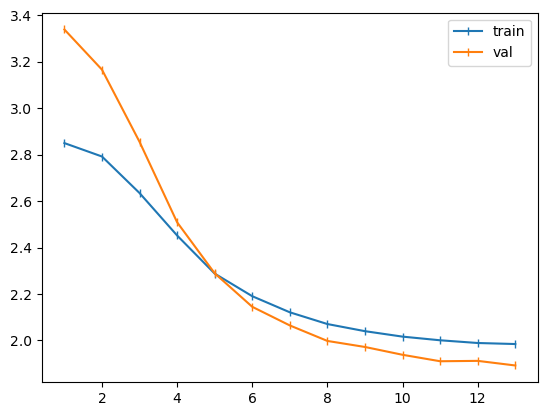

Training Batch 1: Median Loss = 1.908 (0.3 sec/batch)
Training Batch 26: Median Loss = 1.971 (6.7 sec/batch)
Training Batch 51: Median Loss = 1.970 (7.1 sec/batch)
Training Batch 76: Median Loss = 1.967 (6.8 sec/batch)
Training Batch 101: Median Loss = 1.960 (6.5 sec/batch)
Training Batch 126: Median Loss = 1.964 (7.0 sec/batch)
Training Batch 151: Median Loss = 1.964 (6.7 sec/batch)
Training Batch 176: Median Loss = 1.968 (6.5 sec/batch)
Training Batch 201: Median Loss = 1.967 (6.7 sec/batch)
Training Batch 226: Median Loss = 1.968 (6.6 sec/batch)
Training Batch 251: Median Loss = 1.965 (6.5 sec/batch)
Training Batch 276: Median Loss = 1.964 (6.3 sec/batch)
Training Batch 301: Median Loss = 1.967 (6.0 sec/batch)
Training Batch 326: Median Loss = 1.969 (5.4 sec/batch)
Training Batch 351: Median Loss = 1.970 (5.4 sec/batch)
Training Batch 376: Median Loss = 1.974 (6.2 sec/batch)
Training Batch 401: Median Loss = 1.976 (6.3 sec/batch)
Training Batch 426: Median Loss = 1.975 (5.5 sec/batc

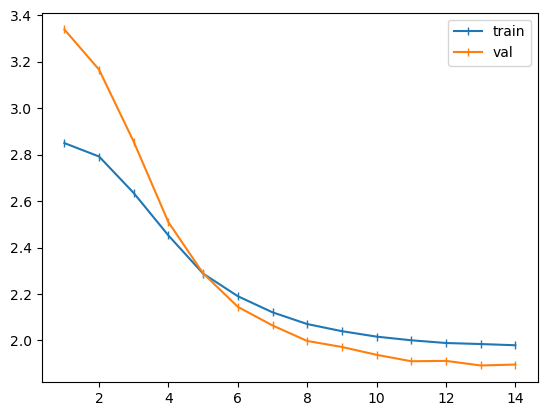

Training Batch 1: Median Loss = 2.100 (0.2 sec/batch)
Training Batch 26: Median Loss = 2.002 (5.1 sec/batch)
Training Batch 51: Median Loss = 1.979 (5.1 sec/batch)
Training Batch 76: Median Loss = 1.978 (5.0 sec/batch)
Training Batch 101: Median Loss = 1.996 (5.0 sec/batch)
Training Batch 126: Median Loss = 1.995 (5.0 sec/batch)
Training Batch 151: Median Loss = 1.980 (6.1 sec/batch)
Training Batch 176: Median Loss = 1.972 (5.5 sec/batch)
Training Batch 201: Median Loss = 1.971 (7.7 sec/batch)
Training Batch 226: Median Loss = 1.968 (7.8 sec/batch)
Training Batch 251: Median Loss = 1.973 (5.4 sec/batch)
Training Batch 276: Median Loss = 1.972 (6.6 sec/batch)
Training Batch 301: Median Loss = 1.970 (7.8 sec/batch)
Training Batch 326: Median Loss = 1.970 (6.3 sec/batch)
Training Batch 351: Median Loss = 1.971 (5.4 sec/batch)
Training Batch 376: Median Loss = 1.972 (5.7 sec/batch)
Training Batch 401: Median Loss = 1.973 (7.6 sec/batch)
Training Batch 426: Median Loss = 1.971 (6.1 sec/batc

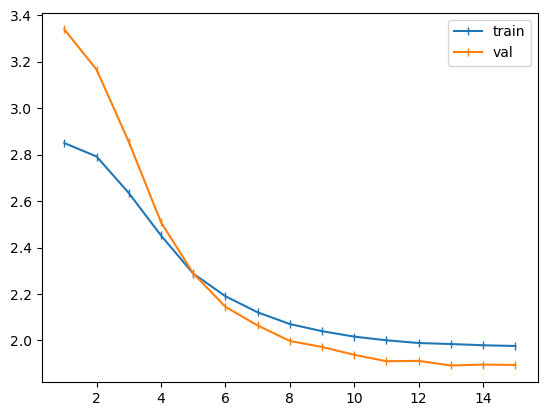

In [42]:

roberta.to(device)
skip_amount = 25

train_losses = []
val_losses = []

for epoch in range(epochs):

    running_train_loss = []
    start = time.time()
    roberta.train()
    for i, (x, attention, y) in enumerate(train_dl):
        optimizer.zero_grad()

        x = x.to(device)
        attention = attention.to(device)
        y = y.to(device)

        output = roberta(x, attention).logits
        # print(output.shape, y.shape)
        loss = F_loss(output.permute(0, 2, 1), y)
        loss.backward()
        optimizer.step()

        scheduler.step()

        running_train_loss.append(loss.item())
        if i % skip_amount == 0:
            print(f"Training Batch {i+1}: Median Loss = {np.median(running_train_loss):.3f} ({(time.time() - start)/skip_amount:.1f} sec/batch)")

            start = time.time()

    running_val_loss = []
    start = time.time()
    roberta.eval()
    for i, (x, attention, y) in enumerate(val_dl):

        x = x.to(device)
        attention = attention.to(device)
        y = y.to(device)

        with torch.no_grad():
            output = roberta(x, attention).logits
            loss = F_loss(output.permute(0, 2, 1), y)


        running_val_loss.append(loss.item())
        if i % skip_amount == 0:
            print(f"Val Batch {i+1}: Median Loss = {np.median(running_val_loss):.3f} ({(time.time() - start)/skip_amount:.1f} sec/batch)")
            
            start = time.time()
    
    output = output.detach().cpu()
    B_ = output.shape[0]
    predictions = torch.argmax(output, dim=-1)
    
    augmented_mask = y.detach().cpu() != -100
    pad_mask    = ~augmented_mask & (x.detach().cpu() == tokenizer.mask_token_id)
    
    output_text = x.detach().cpu()
    output_text[augmented_mask] = predictions[augmented_mask]
    output_text[pad_mask]       = tokenizer.pad_token_id 
    print(tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(x[0])))
    print(tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(output_text[0])))

    train_losses.append(np.mean(running_train_loss))
    val_losses.append(np.mean(running_val_loss))




    plt.plot(list(range(1, epoch+2)), train_losses, label='train', marker='|')
    plt.plot(list(range(1, epoch+2)), val_losses, label='val', marker='|')

    plt.legend(loc='best')

    plt.show()

In [43]:
torch.save(roberta.state_dict(), "roberta_finetuned.pt")

(array([  41.,   87.,  182.,  590., 1915., 1708.,  536.,  225.,   64.,
          28.]),
 array([-0.02130361, -0.01700258, -0.01270155, -0.00840052, -0.00409949,
         0.00020154,  0.00450257,  0.00880361,  0.01310464,  0.01740567,
         0.0217067 ]),
 <BarContainer object of 10 artists>)

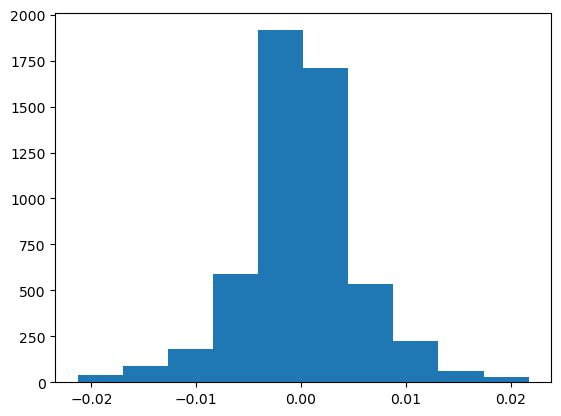

In [59]:
plt.hist(roberta.roberta.encoder.layer[0].attention.self.query.lora_B.data.cpu().numpy().flatten())